In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import community.community_louvain as community
import seaborn as sns
from scipy import stats

df = pd.read_csv('Transmission_Lines.csv')

In [2]:
G = nx.Graph()

# Add edges from transmission lines
for _, row in df.iterrows():
    G.add_edge(row['from'], row['to'], 
               weight=row['length_km'],
               voltage=row['voltage_kv'])

# Basic network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 257
Number of edges: 284


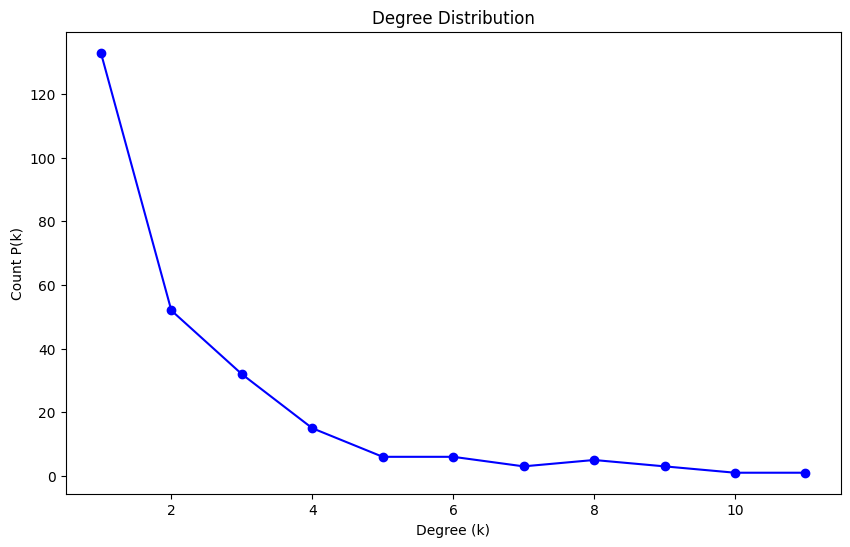

In [3]:
# 1. Degree Distribution P(k)
degrees = [d for n, d in G.degree()]
degree_count = Counter(degrees)
deg, cnt = zip(*sorted(degree_count.items()))

plt.figure(figsize=(10, 6))
plt.plot(deg, cnt, 'bo-')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('Count P(k)')
plt.title('Degree Distribution')
plt.show()

In [4]:
# 3. Clustering Coefficient
# Global clustering coefficient
C = nx.average_clustering(G)
print(f"Global Clustering Coefficient: {C:.3f}")

Global Clustering Coefficient: 0.055


In [5]:
# Random network clustering coefficient for comparison
G_rand = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())
C_rand = nx.average_clustering(G_rand)
print(f"Random Network Clustering Coefficient: {C_rand:.3f}")

Random Network Clustering Coefficient: 0.009


In [7]:
# Clustering coefficient vs degree
clustering_by_degree = {}
for node in G.nodes():
    k = G.degree(node)
    if k not in clustering_by_degree:
        clustering_by_degree[k] = []
    clustering_by_degree[k].append(nx.clustering(G, node))

avg_clustering_by_degree = {k: np.mean(v) for k, v in clustering_by_degree.items()}

plt.figure(figsize=(10, 6))
plt.plot(list(avg_clustering_by_degree.keys()), 
         list(avg_clustering_by_degree.values()), 'ro-')
plt.xscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('Clustering Coefficient C(k)')
plt.title('Clustering Coefficient vs Degree')
plt.grid(True)
plt.savefig('clustering_vs_degree.png')
plt.close()

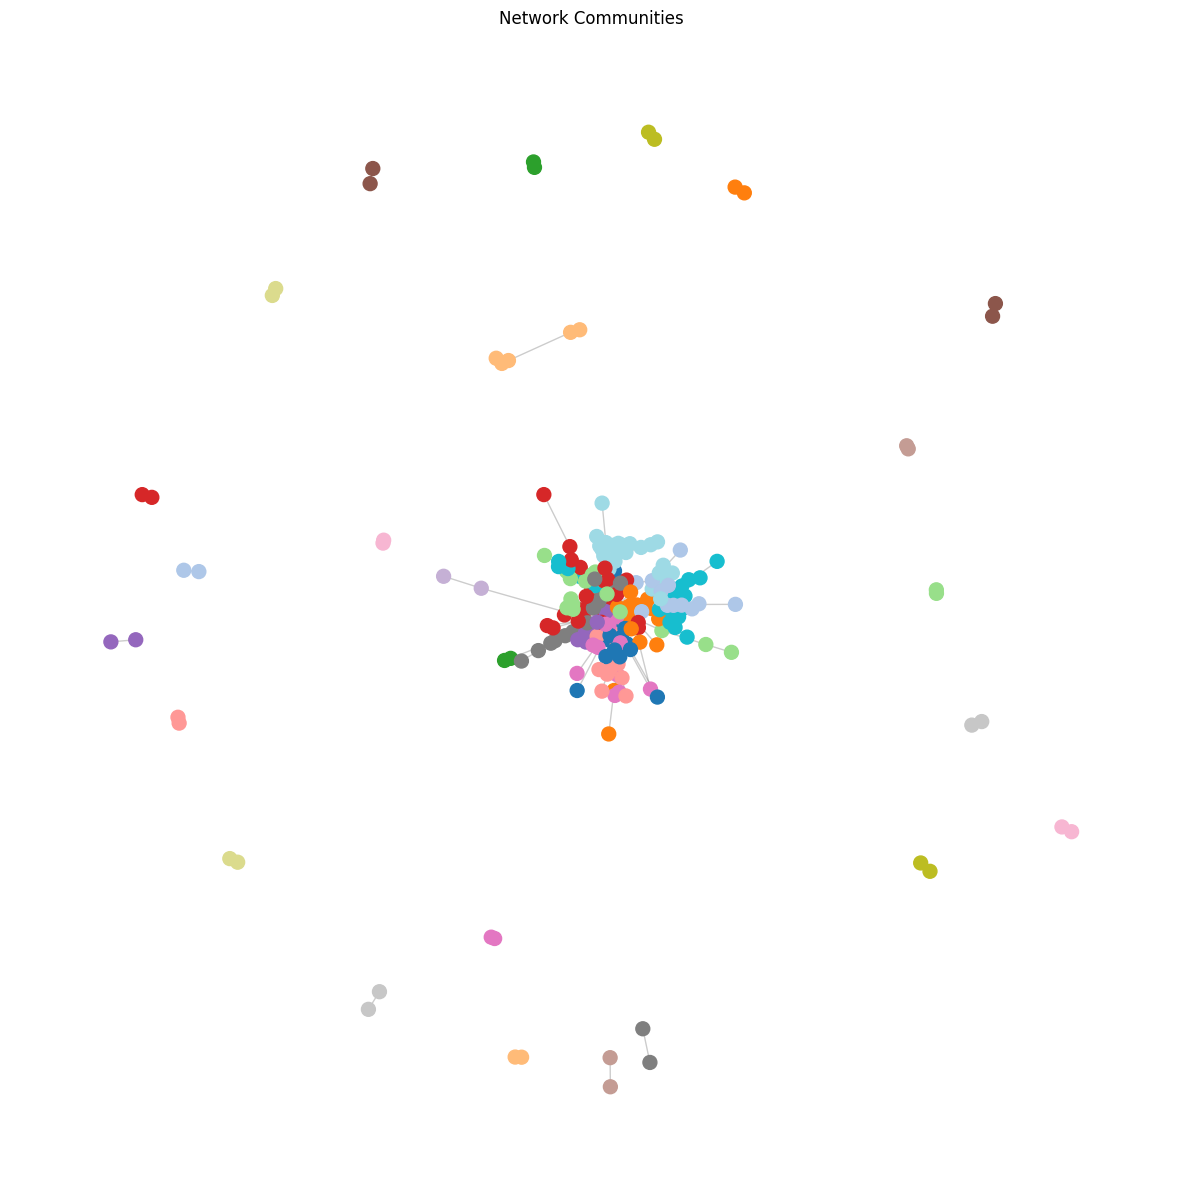

In [8]:
# 4. Community Detection and Visualization
# Detect communities
communities = community.best_partition(G)
nx.set_node_attributes(G, communities, 'community')

# Visualization with communities
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()))
nx.draw_networkx_nodes(G, pos, 
                      node_color=list(communities.values()),
                      node_size=100,
                      cmap=plt.cm.tab20)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title('Network Communities')
plt.axis('off')
plt.show()

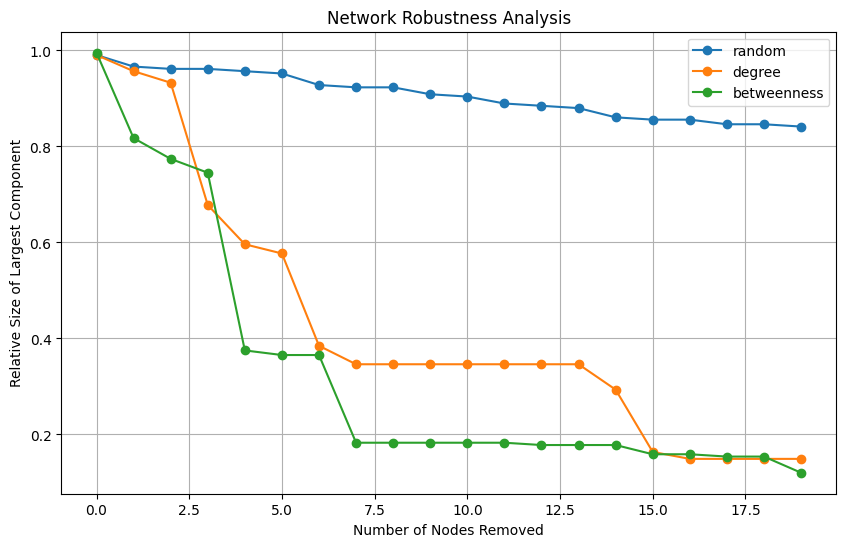

In [9]:
# 6. Network Robustness Analysis
def network_robustness_analysis(G, n_removals=20):
    # Calculate initial largest component size
    initial_size = len(max(nx.connected_components(G), key=len))
    
    # Different attack strategies
    results = {
        'random': [],
        'degree': [],
        'betweenness': []
    }
    
    # Random failure
    G_random = G.copy()
    nodes_random = list(G_random.nodes())
    np.random.shuffle(nodes_random)
    
    # Targeted attack (highest degree first)
    G_degree = G.copy()
    nodes_degree = sorted(G_degree.degree(), key=lambda x: x[1], reverse=True)
    nodes_degree = [n[0] for n in nodes_degree]
    
    # Targeted attack (highest betweenness centrality first)
    G_between = G.copy()
    between_cent = nx.betweenness_centrality(G_between)
    nodes_between = sorted(between_cent.items(), key=lambda x: x[1], reverse=True)
    nodes_between = [n[0] for n in nodes_between]
    
    # Remove nodes and calculate largest component size
    for i in range(n_removals):
        # Random failure
        if nodes_random:
            G_random.remove_node(nodes_random[i])
            size = len(max(nx.connected_components(G_random), key=len))
            results['random'].append(size/initial_size)
            
        # Degree-based attack
        if nodes_degree:
            G_degree.remove_node(nodes_degree[i])
            size = len(max(nx.connected_components(G_degree), key=len))
            results['degree'].append(size/initial_size)
            
        # Betweenness-based attack
        if nodes_between:
            G_between.remove_node(nodes_between[i])
            size = len(max(nx.connected_components(G_between), key=len))
            results['betweenness'].append(size/initial_size)
    
    return results


# Perform robustness analysis
robustness_results = network_robustness_analysis(G)

# Plot robustness results
plt.figure(figsize=(10, 6))
for strategy, sizes in robustness_results.items():
    plt.plot(range(len(sizes)), sizes, '-o', label=strategy)
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Relative Size of Largest Component')
plt.title('Network Robustness Analysis')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Additional Network Metrics
print("\nAdditional Network Metrics:")
print(f"Network Density: {nx.density(G):.3f}")
# print(f"Network Diameter: {nx.diameter(G)}")
# print(f"Network Radius: {nx.radius(G)}")
print(f"Average Degree: {np.mean(degrees):.2f}")
print(f"Network Assortativity: {nx.degree_assortativity_coefficient(G):.3f}")


Additional Network Metrics:
Network Density: 0.009
Average Degree: 2.21
Network Assortativity: 0.009


In [25]:
# Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

print("\nTop 5 nodes by different centrality measures:")
print("\nDegree Centrality:")
for node, cent in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node}: {cent:.3f}")

print("\nBetweenness Centrality:")
for node, cent in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node}: {cent:.3f}")

print("\nCloseness Centrality:")
for node, cent in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node}: {cent:.3f}")


Top 5 nodes by different centrality measures:

Degree Centrality:
Haripur: 0.043
Madunaghat: 0.039
Aminbazar: 0.035
Comilla (N): 0.035
Rampura: 0.035

Betweenness Centrality:
Meghnaghat: 0.196
Comilla (N): 0.187
Ashuganj: 0.177
Aminbazar: 0.176
Ghorasal: 0.169

Closeness Centrality:
Meghnaghat: 0.200
Ghorasal: 0.196
Comilla (N): 0.195
Aminbazar: 0.192
Ashuganj: 0.191
